#1 – Setup & paths

In [1]:
# 1. Basic imports & paths (Colab style)

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

# Base directory for your project
base_dir = "/content/drive/MyDrive/face_liveness_rose"

# Original CSV created by your previous pipeline
orig_csv_path = f"{base_dir}/metadata/rose_youtu_filelist.csv"

# New CSV with updated train/val/test split
new_csv_path = f"{base_dir}/metadata/rose_youtu_filelist_split.csv"

print("Base dir:", base_dir)
print("Original CSV:", orig_csv_path)
print("New CSV will be:", new_csv_path)


Mounted at /content/drive
Base dir: /content/drive/MyDrive/face_liveness_rose
Original CSV: /content/drive/MyDrive/face_liveness_rose/metadata/rose_youtu_filelist.csv
New CSV will be: /content/drive/MyDrive/face_liveness_rose/metadata/rose_youtu_filelist_split.csv


#2 – Create new train/val/test split

In [2]:
# 2. Create new train / val / test split

# Load original CSV
df = pd.read_csv(orig_csv_path)
print("Original split counts:")
print(df["split"].value_counts())
print()

# Old train and old test (from your previous pipeline)
old_train = df[df["split"] == "train"].reset_index(drop=True)
old_test  = df[df["split"] == "test"].reset_index(drop=True)

print("Old train size:", len(old_train))
print("Old test  size:", len(old_test))

# Advisor requested sizes
train_count = 1391
val_count   = 350

# Shuffle only the old train set
old_train = old_train.sample(frac=1, random_state=42).reset_index(drop=True)

# New train and validation from old_train
train_df = old_train.iloc[:train_count].copy()
val_df   = old_train.iloc[train_count : train_count + val_count].copy()

# Test set = old_test unchanged
test_df  = old_test.copy()

# Assign new split labels
train_df["split"] = "train"
val_df["split"]   = "val"
test_df["split"]  = "test"

# Combine into new dataframe
df_new = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

# Save new CSV
os.makedirs(os.path.dirname(new_csv_path), exist_ok=True)
df_new.to_csv(new_csv_path, index=False)

print("New split counts:")
print(df_new["split"].value_counts())
print("\nSaved to:", new_csv_path)


Original split counts:
split
test     1749
train    1748
Name: count, dtype: int64

Old train size: 1748
Old test  size: 1749
New split counts:
split
test     1749
train    1391
val       350
Name: count, dtype: int64

Saved to: /content/drive/MyDrive/face_liveness_rose/metadata/rose_youtu_filelist_split.csv


#3 – Imports for PyTorch, OpenCV, transforms

In [3]:
# 3. Torch / vision imports and transforms

import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Load new split CSV
df = pd.read_csv(new_csv_path)
print(df.head())
print(df["split"].value_counts())

# ImageNet normalization (for MobileNetV3)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Train transform (you can add augmentation later if you want)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# Val/Test transforms (no augmentation)
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


                                          video_path  \
0  /content/drive/MyDrive/face_liveness_rose/vide...   
1  /content/drive/MyDrive/face_liveness_rose/vide...   
2  /content/drive/MyDrive/face_liveness_rose/vide...   
3  /content/drive/MyDrive/face_liveness_rose/vide...   
4  /content/drive/MyDrive/face_liveness_rose/vide...   

                   filename   L   S    D   X  E  person_token  index_token  \
0     Mf_NT_5s_g_E_5_71.mp4  Mf  NT   5s   g  E             5           71   
1  Vm_NT_ZTE_wg_E_2_180.mp4  Vm  NT  ZTE  wg  E             2          180   
2   Vl_NT_ZTE_g_E_6_157.mp4  Vl  NT  ZTE   g  E             6          157   
3     G_NT_IP_wg_E_5_40.mp4   G  NT   IP  wg  E             5           40   
4     G_NT_HS_wg_E_9_16.mp4   G  NT   HS  wg  E             9           16   

   person_id  label attack_type  split  
0          5      0        mask  train  
1          2      0      replay  train  
2          6      0      replay  train  
3          5      1     genuin

#4 – Create train/val/test dataframes

In [4]:
# 4. Split dataframe into train / val / test subsets

train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

print("Train videos:", len(train_df))
print("Val   videos:", len(val_df))
print("Test  videos:", len(test_df))

Train videos: 1391
Val   videos: 350
Test  videos: 1749


#5 – Dataset class (random frame vs first frame)

In [5]:
# 5. Custom Dataset: random frame for train, first frame for val/test

class RoseYoutuFrameDataset(Dataset):
    def __init__(self, df, transform=None, mode="train", max_attempts=5):
        """
        mode: "train" -> random frame
              "val" or "test" -> first frame
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.mode = mode
        self.max_attempts = max_attempts

    def __len__(self):
        return len(self.df)

    def _read_frame(self, video_path, random_frame=True):
        """
        If random_frame=True -> pick a random frame.
        Else -> always take the first frame (index 0).
        """
        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Video not found: {video_path}")

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise IOError(f"Could not open video: {video_path}")

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            cap.release()
            raise ValueError(f"No frames in video: {video_path}")

        if random_frame:
            frame_idx = torch.randint(low=0, high=total_frames, size=(1,)).item()
        else:
            frame_idx = 0  # first frame

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()

        if not ret or frame is None:
            raise ValueError(f"Failed to read frame {frame_idx} from {video_path}")

        # BGR -> RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = row["video_path"]
        label = int(row["label"])

        # Decide frame selection mode
        random_frame = (self.mode == "train")

        # Try multiple times in case of bad frame
        for _ in range(self.max_attempts):
            try:
                img = self._read_frame(video_path, random_frame=random_frame)
                break
            except Exception as e:
                last_error = e
        else:
            # If all attempts fail, raise last error
            raise last_error

        if self.transform is not None:
            img = self.transform(img)

        return img, label


#6 – Create DataLoaders

In [6]:
# 6. Create Datasets and DataLoaders

batch_size = 32

train_dataset = RoseYoutuFrameDataset(
    train_df, transform=train_transform, mode="train"
)
val_dataset = RoseYoutuFrameDataset(
    val_df, transform=eval_transform, mode="val"
)
test_dataset = RoseYoutuFrameDataset(
    test_df, transform=eval_transform, mode="test"
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,       # shuffle for training
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,      # DO NOT shuffle validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,      # DO NOT shuffle test
    num_workers=2,
    pin_memory=True
)

len(train_loader), len(val_loader), len(test_loader)


(44, 11, 55)

#7 – Sanity check shapes

In [9]:
# 7. Sanity check one training batch

batch = next(iter(train_loader))
images, labels = batch

print("Images shape:", images.shape)   # [batch_size, 3, 224, 224]
print("Labels shape:", labels.shape)   # [batch_size]
print("First 10 labels:", labels[:10])


Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
First 10 labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0])


#8 – Load MobileNetV3-Large and modify last layer

In [10]:
# 8. Model: MobileNetV3-Large (pretrained) with 1 output

import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained MobileNetV3-Large
model = models.mobilenet_v3_large(
    weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1
)

# Replace last classification layer with 1 output neuron
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, 1)

model = model.to(device)
print(model.classifier)


Using device: cpu
Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1, bias=True)
)


#9 – Loss function & optimizer

In [11]:
# 9. Loss and optimizer

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)


#10 – Training & evaluation functions (with FAR/FRR/HTER)

In [12]:
# 10. Train one epoch & evaluate with FAR, FRR, HTER

def compute_metrics(labels, preds):
    """
    labels: tensor of 0/1
    preds:  tensor of 0/1 (after threshold)
    Returns: accuracy, FAR, FRR, HTER
    """
    labels = labels.cpu()
    preds = preds.cpu()

    TP = ((preds == 1) & (labels == 1)).sum().item()
    TN = ((preds == 0) & (labels == 0)).sum().item()
    FP = ((preds == 1) & (labels == 0)).sum().item()
    FN = ((preds == 0) & (labels == 1)).sum().item()

    total = TP + TN + FP + FN
    acc = (TP + TN) / total if total > 0 else 0.0

    # FAR: spoof classified as real => FP / (FP + TN)
    denom_far = FP + TN
    FAR = FP / denom_far if denom_far > 0 else 0.0

    # FRR: real classified as spoof => FN / (FN + TP)
    denom_frr = FN + TP
    FRR = FN / denom_frr if denom_frr > 0 else 0.0

    HTER = (FAR + FRR) / 2.0

    return acc, FAR, FRR, HTER


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(images).squeeze(1)  # [batch]
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        # Predictions
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()

        all_labels.append(labels.long().cpu())
        all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    avg_loss = total_loss / len(loader.dataset)
    acc, FAR, FRR, HTER = compute_metrics(all_labels, all_preds)

    return avg_loss, acc, FAR, FRR, HTER


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long()

            all_labels.append(labels.long().cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    avg_loss = total_loss / len(loader.dataset)
    acc, FAR, FRR, HTER = compute_metrics(all_labels, all_preds)

    return avg_loss, acc, FAR, FRR, HTER


#11. Main training loop (with val metrics)

In [12]:
# 11. Main training loop with "best val loss" checkpoint saving

epochs = 10

history = {
    "train_loss": [],
    "train_acc": [],
    "train_FAR": [],
    "train_FRR": [],
    "train_HTER": [],
    "val_loss": [],
    "val_acc": [],
    "val_FAR": [],
    "val_FRR": [],
    "val_HTER": [],
}

best_val_loss = float("inf")   # track best (lowest) validation loss
best_model_path = f"{base_dir}/checkpoints/mobilenetv3_best_val_loss.pth"
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)

for epoch in range(1, epochs + 1):
    # ---- TRAIN ----
    train_loss, train_acc, train_FAR, train_FRR, train_HTER = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # ---- VALIDATION ----
    val_loss, val_acc, val_FAR, val_FRR, val_HTER = evaluate(
        model, val_loader, criterion, device
    )

    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_FAR"].append(train_FAR)
    history["train_FRR"].append(train_FRR)
    history["train_HTER"].append(train_HTER)

    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_FAR"].append(val_FAR)
    history["val_FRR"].append(val_FRR)
    history["val_HTER"].append(val_HTER)

    # ---- CHECKPOINT: save best model by validation loss ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"  >>> New best model saved (val_loss = {val_loss:.4f})")

    # Logging
    print(f"Epoch {epoch}/{epochs}")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
          f"FAR: {train_FAR:.4f}, FRR: {train_FRR:.4f}, HTER: {train_HTER:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, "
          f"FAR: {val_FAR:.4f}, FRR: {val_FRR:.4f}, HTER: {val_HTER:.4f}")


  >>> New best model saved (val_loss = 0.0930)
Epoch 1/10
  Train - Loss: 0.2531, Acc: 0.9015, FAR: 0.0338, FRR: 0.2857, HTER: 0.1598
  Val   - Loss: 0.0930, Acc: 0.9714, FAR: 0.0191, FRR: 0.0568, HTER: 0.0380
  >>> New best model saved (val_loss = 0.0537)
Epoch 2/10
  Train - Loss: 0.0218, Acc: 0.9971, FAR: 0.0010, FRR: 0.0084, HTER: 0.0047
  Val   - Loss: 0.0537, Acc: 0.9886, FAR: 0.0000, FRR: 0.0455, HTER: 0.0227
Epoch 3/10
  Train - Loss: 0.0091, Acc: 0.9971, FAR: 0.0019, FRR: 0.0056, HTER: 0.0038
  Val   - Loss: 0.0884, Acc: 0.9714, FAR: 0.0000, FRR: 0.1136, HTER: 0.0568
Epoch 4/10
  Train - Loss: 0.0037, Acc: 1.0000, FAR: 0.0000, FRR: 0.0000, HTER: 0.0000
  Val   - Loss: 0.0965, Acc: 0.9686, FAR: 0.0000, FRR: 0.1250, HTER: 0.0625
  >>> New best model saved (val_loss = 0.0360)
Epoch 5/10
  Train - Loss: 0.0105, Acc: 0.9964, FAR: 0.0010, FRR: 0.0112, HTER: 0.0061
  Val   - Loss: 0.0360, Acc: 0.9886, FAR: 0.0000, FRR: 0.0455, HTER: 0.0227
Epoch 6/10
  Train - Loss: 0.0167, Acc: 0.99

#12 – Load best model and evaluate on test set

In [13]:
# 12. Load best (val loss) model and evaluate on test set

best_model_path = f"{base_dir}/checkpoints/mobilenetv3_best_val_loss.pth"

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Loaded best model from:", best_model_path)
else:
    print("Best model file not found, using current model weights.")

test_loss, test_acc, test_FAR, test_FRR, test_HTER = evaluate(
    model, test_loader, criterion, device
)

print("\n=== Final Test Results (Best Val Loss Model) ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")
print(f"Test FAR : {test_FAR:.4f}")
print(f"Test FRR : {test_FRR:.4f}")
print(f"Test HTER: {test_HTER:.4f}")


Loaded best model from: /content/drive/MyDrive/face_liveness_rose/checkpoints/mobilenetv3_best_val_loss.pth

=== Final Test Results (Best Val Loss Model) ===
Test Loss: 0.0403
Test Acc : 0.9863
Test FAR : 0.0000
Test FRR : 0.0535
Test HTER: 0.0267


#13 – Save model checkpoint

In [14]:
# 13. Save best model

checkpoint_dir = f"{base_dir}/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

save_path = os.path.join(checkpoint_dir, "mobilenetv3_liveness_best_valHTER.pth")
torch.save(model.state_dict(), save_path)

print("Model saved to:", save_path)


Model saved to: /content/drive/MyDrive/face_liveness_rose/checkpoints/mobilenetv3_liveness_best_valHTER.pth


# 1. Grad-CAM

In [20]:
# 14. Grad-CAM for MobileNetV3

import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: your trained model
        target_layer: the conv layer to hook (e.g. model.features[-1])
        """
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # forward hook: save feature maps
        self.fwd_hook = target_layer.register_forward_hook(self._forward_hook)
        # backward hook: save gradients wrt feature maps
        self.bwd_hook = target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        # grad_output is a tuple; index 0 is gradient wrt module output
        self.gradients = grad_output[0].detach()

    def __call__(self, input_tensor, target_class=None):
        """
        input_tensor: 1 x 3 x H x W
        target_class: 0 or 1. If None, use predicted class.
        Returns: heatmap (H, W) in [0, 1]
        """
        self.model.eval()
        self.model.zero_grad()

        # Forward pass
        output = self.model(input_tensor)  # shape [1, 1]
        output = output.squeeze(0)        # [1] or scalar

        # Decide which class logit to use
        if target_class is None:
            # For binary logit, >0 => class 1, <0 => class 0
            pred_class = 1 if output.item() >= 0 else 0
        else:
            pred_class = int(target_class)

        # For BCE-with-logits with 1 logit, use:
        #   logit for class 1 = output
        #   logit for class 0 = -output
        if pred_class == 1:
            score = output
        else:
            score = -output

        # Backward to get gradients
        score.backward()

        # activations: [1, C, H, W], gradients: [1, C, H, W]
        activations = self.activations  # (1, C, H, W)
        gradients = self.gradients      # (1, C, H, W)

        # Global average pooling of gradients over H,W -> weights for each channel
        alpha = gradients.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)

        # Weighted sum of activations
        weighted = (alpha * activations).sum(dim=1, keepdim=True)  # (1, 1, H, W)

        # Remove batch/channel dims -> (H, W)
        cam = weighted.squeeze().cpu().numpy()

        # ReLU: keep positive contributions only
        cam = np.maximum(cam, 0)

        # Normalize to [0, 1]
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

        return cam


#2. Grad-CAM

In [21]:
# 15. Utility: unnormalize and visualize Grad-CAM

# Reuse your ImageNet mean/std
mean = np.array(imagenet_mean)
std = np.array(imagenet_std)

def tensor_to_img(tensor):
    """
    Convert a normalized tensor [3, H, W] back to a uint8 HxWx3 image.
    """
    img = tensor.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # C,H,W -> H,W,C
    img = img * std + mean              # unnormalize
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

def show_gradcam_on_image(img, cam, alpha=0.4):
    """
    img: uint8 HxWx3 (original image)
    cam: HxW heatmap in [0, 1]
    alpha: blending factor
    """
    import cv2

    h, w, _ = img.shape
    cam_resized = cv2.resize(cam, (w, h))

    # Convert cam to color heatmap
    heatmap = (cam_resized * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Overlay
    overlay = (alpha * heatmap + (1 - alpha) * img).astype(np.uint8)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM")
    plt.imshow(cam_resized, cmap="jet")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


#3. Grad-CAM

True label: 0 (0=attack, 1=real)


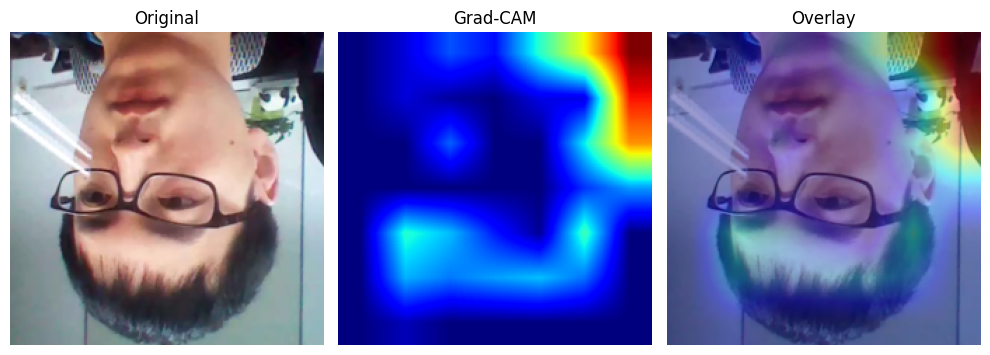

In [22]:
# 16. Run Grad-CAM on a few test samples

# Choose the last conv layer of MobileNetV3
target_layer = model.features[-1]   # adjust if needed
gradcam = GradCAM(model, target_layer)

# Take one batch from test_loader
batch = next(iter(test_loader))
images, labels = batch  # images: [B, 3, H, W], labels: [B]

# Pick an index from the batch (e.g., 0)
idx = 0
img_tensor = images[idx:idx+1].to(device)  # keep batch dimension
label = labels[idx].item()

print(f"True label: {label} (0=attack, 1=real)")

# Get Grad-CAM heatmap (for predicted class)
cam = gradcam(img_tensor, target_class=None)

# Convert tensor to image and show
orig_img = tensor_to_img(images[idx])
show_gradcam_on_image(orig_img, cam)


#1. t-SNE

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Feature shape: (1749, 1280)
Labels shape: (1749,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1749 samples in 0.002s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 1749 samples in 0.484s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1749
[t-SNE] Computed conditional probabilities for sample 1749 / 1749
[t-SNE] Mean sigma: 6.464641
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.412849
[t-SNE] KL divergence after 1000 iterations: 1.070077


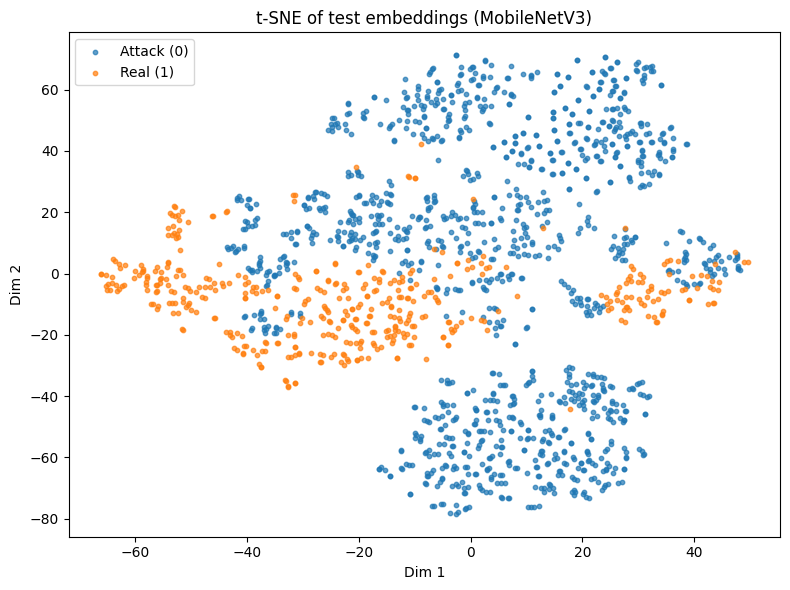

In [23]:
# 17. t-SNE visualization of embeddings

from sklearn.manifold import TSNE

# Build a feature extractor: everything except the last linear layer
feature_extractor = torch.nn.Sequential(
    model.features,
    model.avgpool,
    torch.nn.Flatten(start_dim=1),
    *list(model.classifier[:-1])   # take all classifier layers except final Linear
).to(device)

feature_extractor.eval()

all_feats = []
all_labels = []

# You can use full test set, or subset if too slow (e.g. first N batches)
max_batches = None  # set to e.g. 20 if you want to limit

with torch.no_grad():
    for b_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        feats = feature_extractor(images)   # shape [B, D]

        all_feats.append(feats.cpu())
        all_labels.append(labels.cpu())

        if (max_batches is not None) and (b_idx + 1 >= max_batches):
            break

all_feats = torch.cat(all_feats, dim=0).numpy()   # [N, D]
all_labels = torch.cat(all_labels, dim=0).numpy() # [N]

print("Feature shape:", all_feats.shape)
print("Labels shape:", all_labels.shape)

# Run t-SNE to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, verbose=1)
feats_2d = tsne.fit_transform(all_feats)   # [N, 2]

# Plot
plt.figure(figsize=(8, 6))

# Boolean masks
mask_real = (all_labels == 1)
mask_attack = (all_labels == 0)

plt.scatter(feats_2d[mask_attack, 0], feats_2d[mask_attack, 1],
            s=10, label="Attack (0)", alpha=0.7)
plt.scatter(feats_2d[mask_real, 0], feats_2d[mask_real, 1],
            s=10, label="Real (1)", alpha=0.7)

plt.legend()
plt.title("t-SNE of test embeddings (MobileNetV3)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()
